### Overview of the Process

The goal of this workflow is to **predict flight departure delays** using machine learning. Here's a summary:

1. **Data Preparation**:
   - Load flight data, focusing on a specific airline (e.g., American Airlines).
   - Create useful features like `heure_depart_min` (departure time in seconds) and convert categorical data (e.g., airports) into numeric or vector formats.

2. **Feature Engineering**:
   - Standardize numerical data (like time) for consistency.
   - Combine all features into a single vector for model training.

3. **Model Training**:
   - Split the data into training and testing sets (80%-20%).
   - Train multiple models to predict delays:
     - **Linear Regression**: Assumes a straight-line relationship between input features and delays.
     - **Decision Tree**: Creates split-based decision rules.
     - **Gradient Boosted Trees**: Combines decision trees for better predictions.

4. **Model Evaluation**:
   - Use metrics like **Root Mean Squared Error (RMSE)** and **R²** to assess performance.
   - Compare model predictions with actual delays.

5. **Hyperparameter Tuning**:
   - For Linear Regression, test various parameter combinations to find the best-performing model.

6. **Results**:
   - Models like Decision Tree and Gradient Boosted Trees often perform better with non-linear patterns.
   - RMSE values indicate how far off the predictions are from actual delays.

---






#### 1. Setting Up the Environment
We start by setting up everything needed to process and analyze the data:
- PySpark is used for handling large datasets.
- Libraries are imported to handle data transformation, build machine learning models, and evaluate results.

#### 2. Loading the Dataset
We load a file containing flight data. Each row has information like:
- The origin airport.
- Scheduled departure time.
- Delay in departure.

**Example**: A row might look like this:
Airline: AA, Origin Airport: JFK, Departure: 07:30, Delay: 15 minutes


#### 3. Filtering Data for American Airlines
We only keep flights from **American Airlines (AA)** to make the analysis more focused.

**Example**:
- If the dataset has flights from airlines like AA, UA, and DL, we keep only rows where `Airline = AA`.

#### 4. Creating a New Feature (`heure_depart_min`)
We calculate the departure time in **seconds since midnight**.

**Example**:
- Scheduled departure time: `07:30:00`.
- Conversion: \((7 \times 3600) + (30 \times 60) = 27,000 \, \text{seconds}\).

This new feature helps the model understand time numerically.

#### 5. Converting Airports into Numbers
Airports are names like `JFK`, `LAX`, etc., which are not understandable by models. We convert them into numerical or vector formats:
- **StringIndexer** assigns a number to each airport.
  - Example: JFK → 0, LAX → 1, ORD → 2.
- **OneHotEncoder** creates a binary vector for each airport.
  - Example: JFK → `[1, 0, 0]`, LAX → `[0, 1, 0]`, ORD → `[0, 0, 1]`.

#### 6. Normalizing Time Data
The departure time (in seconds) might have very large values compared to other features. We standardize it to ensure all features have similar scales.

**Example**:
- Original times: `[27,000, 28,800, 36,000]`.
- After scaling: `[-0.5, 0.0, 1.5]`.

This helps the model process the data more effectively.

#### 7. Combining All Features
We combine all the features (scaled time, one-hot encoded airport data) into a single column called `features`.

**Example**:
- A row might look like:
Features: [0.5 (scaled time), 1, 0, 0 (JFK encoded)]


#### 8. Calculating the Target Variable
The target variable (`DEPARTURE_DELAY`) is grouped by the features, and the average delay is calculated for each group.

**Example**:
- For flights departing at the same time and airport, we calculate the mean delay.

#### 9. Splitting Data into Train-Test Sets
We divide the data into:
- **Training data** (80%): Used to train the model.
- **Testing data** (20%): Used to check how well the model performs on unseen data.

**Example**:
- Training data: `[flight 1, flight 2, ..., flight 8]`.
- Testing data: `[flight 9, flight 10]`.

#### 10. Training Machine Learning Models
We train three models:
1. **Linear Regression**: Assumes a straight-line relationship between features and delays.
2. **Decision Tree**: Splits data into groups based on conditions (e.g., "Is departure time < 8 AM?").
3. **Gradient Boosted Trees (GBT)**: Combines multiple decision trees for better predictions.

#### 11. Evaluating Models
We evaluate the models using two metrics:
- **Root Mean Squared Error (RMSE)**: Measures how far predictions are from the actual values. Lower RMSE is better.
- **R² (for Linear Regression)**: Measures how well the model explains the data. Higher R² is better.

**Example**:
- Predicted delays: `[12, 15, 20]`.
- Actual delays: `[10, 18, 22]`.
- RMSE quantifies the average difference between these predictions and actual values.

#### 12. Hyperparameter Tuning
For **Linear Regression**, we test different settings (hyperparameters) to improve accuracy:
- **`regParam`**: Controls how much the model simplifies to avoid overfitting.
- **`elasticNetParam`**: Balances between different regularization techniques.

We use **cross-validation**, where the training data is split further to test various parameter combinations.

#### 13. Model Performance Summary
The results show how well each model performed:
1. **Linear Regression**:

2. **Decision Tree**
.
3. **Gradient Boosted Trees**:





In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.sql.functions import hour, minute, second, col, mean
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark session
spark = SparkSession.builder \
    .appName("FlightDelayPrediction") \
    .getOrCreate()

# Load the dataset
file_path = "/content/drive/My Drive/cleaned.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Filter for a specific airline
df_aa = df.filter(df["AIRL"] == "AA")

# Add heure_depart_min feature
df_aa = df_aa.withColumn("heure_depart_min",
                         hour("SCHEDULED_DEPARTURE") * 3600 +
                         minute("SCHEDULED_DEPARTURE") * 60 +
                         second("SCHEDULED_DEPARTURE"))

# Index and encode the airport column before grouping
indexer = StringIndexer(inputCol="ORIGIN_AIRPORT", outputCol="airport_index")
df_aa = indexer.fit(df_aa).transform(df_aa)

encoder = OneHotEncoder(inputCol="airport_index", outputCol="airport_onehot")
df_aa = encoder.fit(df_aa).transform(df_aa)

# Assemble heure_depart_min into a vector
assembler_heure = VectorAssembler(inputCols=["heure_depart_min"], outputCol="heure_depart_min_vector")
df_aa = assembler_heure.transform(df_aa)

# Normalize heure_depart_min
scaler = StandardScaler(inputCol="heure_depart_min_vector", outputCol="scaled_heure_depart_min", withStd=True, withMean=True)
df_aa = scaler.fit(df_aa).transform(df_aa)

# Combine features into a single vector before grouping
assembler = VectorAssembler(
    inputCols=["scaled_heure_depart_min", "airport_onehot"],
    outputCol="features"
)
df_aa = assembler.transform(df_aa)

# Calculate mean departure delay grouped by features
df_aggregated = df_aa.groupBy("features").agg(
    mean("DEPARTURE_DELAY").alias("mean")
)

# Filter out rows with null target variable
df_final = df_aggregated.filter(col("mean").isNotNull())

# Train-test split
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=123)

# Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="mean")
lr_model = lr.fit(train_data)

# Evaluate Linear Regression
training_summary = lr_model.summary
print(f"Linear Regression RMSE: {training_summary.rootMeanSquaredError}")
print(f"Linear Regression R2: {training_summary.r2}")

# Test set predictions
test_results = lr_model.evaluate(test_data)
print(f"Test RMSE: {test_results.rootMeanSquaredError}")
print(f"Test R2: {test_results.r2}")

# Decision Tree Regressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="mean")
dt_model = dt.fit(train_data)

# Evaluate Decision Tree
dt_predictions = dt_model.transform(test_data)
dt_evaluator = RegressionEvaluator(labelCol="mean", predictionCol="prediction", metricName="rmse")
dt_rmse = dt_evaluator.evaluate(dt_predictions)
print(f"Decision Tree RMSE: {dt_rmse}")

# Gradient Boosted Trees
gbt = GBTRegressor(featuresCol="features", labelCol="mean")
gbt_model = gbt.fit(train_data)

# Evaluate Gradient Boosted Trees
gbt_predictions = gbt_model.transform(test_data)
gbt_evaluator = RegressionEvaluator(labelCol="mean", predictionCol="prediction", metricName="rmse")
gbt_rmse = gbt_evaluator.evaluate(gbt_predictions)
print(f"GBT RMSE: {gbt_rmse}")

# Hyperparameter Tuning for Linear Regression
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

evaluator = RegressionEvaluator(labelCol="mean", predictionCol="prediction", metricName="rmse")

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

cv_model = crossval.fit(train_data)
print(f"Best Linear Regression RMSE: {cv_model.bestModel.summary.rootMeanSquaredError}")


Linear Regression RMSE: 27.031973366744065
Linear Regression R2: 0.08392644343107403
Test RMSE: 37.97865689016129
Test R2: -0.014334009407884984
Decision Tree RMSE: 40.86147965318256
GBT RMSE: 41.812274157482896
Best Linear Regression RMSE: 27.236594666864924


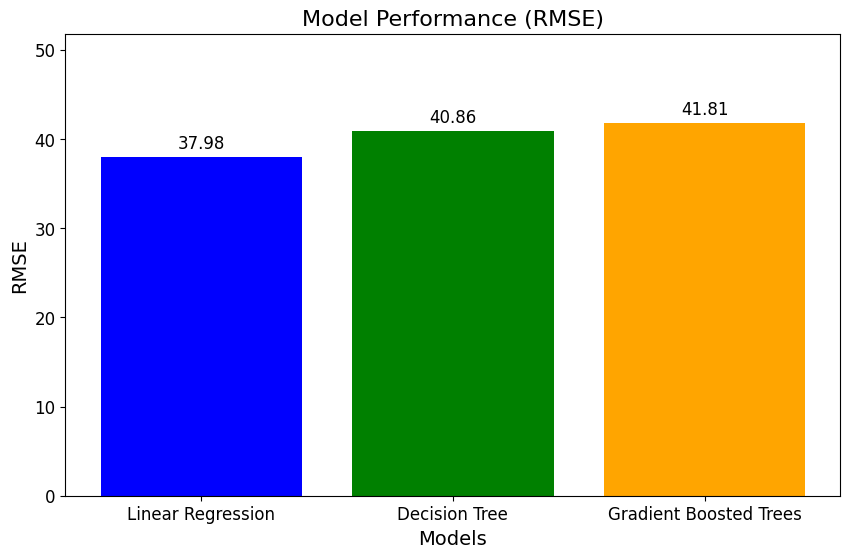

In [ ]:
import matplotlib.pyplot as plt

# Prepare data for visualization
models = ['Linear Regression', 'Decision Tree', 'Gradient Boosted Trees']
rmse_values = [test_results.rootMeanSquaredError, dt_rmse, gbt_rmse]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['blue', 'green', 'orange'])
plt.title('Model Performance (RMSE)', fontsize=16)
plt.ylabel('RMSE', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.ylim(0, max(rmse_values) + 10)  # Add some padding to the y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display RMSE values on top of the bars
for i, v in enumerate(rmse_values):
    plt.text(i, v + 1, f'{v:.2f}', ha='center', fontsize=12)

plt.show()
